In [1]:
# base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Any, Dict, List

# Загрузка данных.

In [2]:
import gdown

url = "https://drive.google.com/file/d/1a9eo-9XzqZ1XFBaqfJHdecoB-oG-ch5B/view?usp=sharing"
output = "data.zip"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1a9eo-9XzqZ1XFBaqfJHdecoB-oG-ch5B
From (redirected): https://drive.google.com/uc?id=1a9eo-9XzqZ1XFBaqfJHdecoB-oG-ch5B&confirm=t&uuid=71c2af4f-25e5-4bb9-b824-f4c8ab1c9ecf
To: /content/data.zip
100%|██████████| 26.6M/26.6M [00:01<00:00, 17.7MB/s]


'data.zip'

In [3]:
!mkdir data
!mkdir data/raw

In [4]:
!unzip data.zip -d data/raw

Archive:  data.zip
  inflating: data/raw/data_final_for_dls_new.jsonl  
  inflating: data/raw/data_final_for_dls_eval_new.jsonl  


In [5]:
!rm data.zip

In [6]:
data_eval = pd.read_json("data/raw/data_final_for_dls_eval_new.jsonl", lines=True)
data = pd.read_json("data/raw/data_final_for_dls_new.jsonl", lines=True)

data.drop(columns='relevance', inplace=True)
data_eval.drop(columns='relevance', inplace=True)

data.rename(columns={'relevance_new': 'relevance'}, inplace=True)
data_eval.rename(columns={'relevance_new': 'relevance'}, inplace=True)

### Небольшая работа с данными

In [7]:
# ВАЖНО! Так как у нас eval - просто первые 570 строк из всех данных.
data_clean = data.iloc[570:]

<Axes: xlabel='relevance', ylabel='count'>

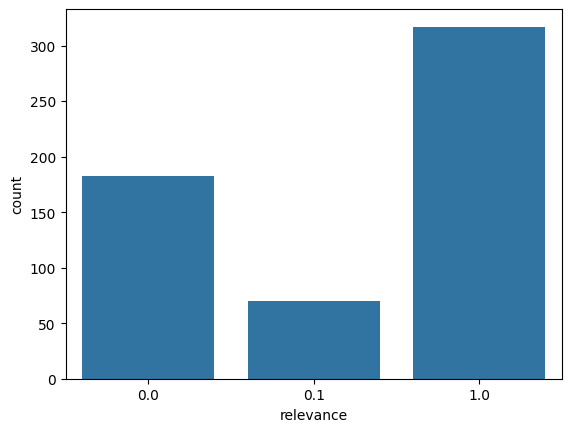

In [8]:
sns.countplot(data=data_eval, x='relevance')

<Axes: xlabel='relevance', ylabel='count'>

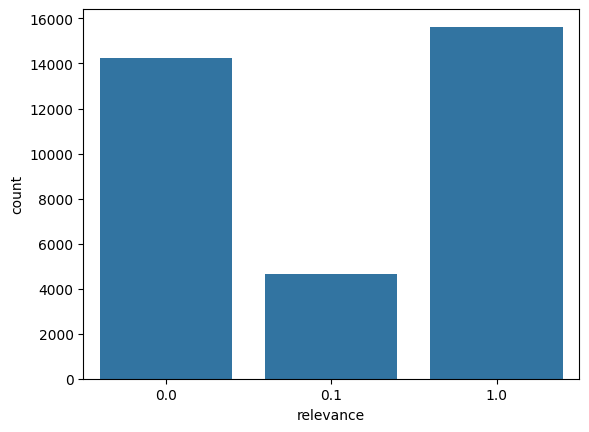

In [9]:
sns.countplot(data=data_clean, x='relevance')

# LLM Classifier

## 1. Подготовка данных: анализ длин, создание промптов (можно не запускать эти ячейки)

### Предобработка и анализ длины в токенах

In [ ]:
def make_object_text_full(row):
    return (
        f"Запрос: {row['Text']}.\n"
        f"Название: {row['name']}\n"
        f"Рубрика: {row['normalized_main_rubric_name_ru']}\n"
        f"Адрес: {row['address']}\n"
        f"Цены: {row['prices_summarized']}\n"
        f"Отзывы: {row['reviews_summarized']}\n"
        f"Релевантность: {row['relevance']}"
    )

document_full = data.apply(make_object_text_full, axis=1)

In [ ]:
print(*document_full.sample(1).to_list())

Запрос: грузовой шиномонтаж.
Название: Шиномонтаж; Tire fitting and repair
Рубрика: Шиномонтаж
Адрес: Москва, Новомосковский административный округ, Филимонковский район, деревня Поповка, Дорожная улица, 34А
Цены: None
Отзывы: Организация занимается шиномонтажом и сопутствующими услугами, такими как ремонт шин и заправка кондиционеров. Тональность отзывов преимущественно положительная: пользователи хвалят качество работы, низкие цены и профессионализм сотрудников. Хвалят: быстрое обслуживание, добросовестную работу, адекватные цены. Критикуют: отсутствие комнаты ожидания и ограниченное пространство для клиентов.

| 1. Мастер своего дела | 2. Быстро и дёшево, понравилось | 3. Добросовестно, быстро, качественно | 4. Всё хорошо | 5. Отличная шинка, рекомендуют | 6. Отличные парни, работают на совесть | 7. Быстро и без очереди, цены вменяемые | 8. Приятный разговор по ремонту, дали совет | 9. Лучший сервис на юго-западе Москвы | 10. Частный шиномонтаж, всё по делу | 11. Хорошо делают колёс

Как будем обрабатывать данные:

В целях эконоимм конеткста, нам надо выкинуть не нежное и оставить нужное.
* **Название** содержит разные вариации, перечисленные через ; . Понятно что нам нужны не все, но в целом, после небольшого просмотра, можно заметить что после 3-4 названия идет повторение, иногда написание на транслите  => **оставим только 3 вариации названия**

* **Рубрика** - берем всю.

* **Адрес** - берем весь.

* **Цены** - Сначала идет суммаризация, потом идут некоторые позиции или какая либо информация. Это очень иформативная и важная колонка, поэтому по хорошему нам стоит ее оставить. (в написанном ниже методе я делал возможность сколько позиций выбрать, в бейзлайне я брал 5, здесь возьмем 10 ибо в целом больше 10 по датасету нет, а если есть, то это просто перечисление позций услуг/товаров которые в целом не так критично пропустить)

* **Отзывы** - здесь идет сначала суммаризация, потом несколько отзывово перечисляют. Отзывы не так полезны и хватит только суммаризации. **Оставим только суммаризацию**

In [ ]:
def make_object_text(row):

    """
    Берет из названий только names_num названий
    Всю рубрику
    Весь адрес
    Только prices_num предложений из цен
    Только начальную ифнформацио об отзывах

    """
    names_num = 5
    prices_num = 10

    # names
    if row['name'] != None:
        name_splitted = row['name'].split(';')
        len_split = min(names_num, len(name_splitted))
        names_take = " ; ".join(name_splitted[:len_split])
    else:
        names_take = None


    # take prices
    if row['prices_summarized'] != None:
        prices_splited = row['prices_summarized'].split('|')
        len_split = min(prices_num + 1, len(prices_splited))
        prices_take = " | ".join(prices_splited[:len_split])
    else:
        prices_take = None

    # take reviews
    if row['reviews_summarized'] != None:
        rev_splited = row['reviews_summarized'].split('|')
        rev_take = rev_splited[0]

        # then split by \n
        rev_splited = rev_take.split('\n')
        rev_take = rev_splited[0]
    else:
        rev_take = None

    return (
        f"Запрос: {row['Text']}.\n"
        f"Название: {names_take}\n"
        f"Рубрика: {row['normalized_main_rubric_name_ru']}\n"
        f"Адрес: {row['address']}\n"
        f"Цены: {prices_take}\n"
        f"Отзывы: {rev_take}"
    )

document = data_clean.apply(make_object_text, axis=1)
document_val = data_eval.apply(make_object_text, axis=1)

Посмотрим на длины получившихся документов

Loading weights:   0%|          | 0/310 [00:00<?, ?it/s]

Model's maximum sequence length: 32768


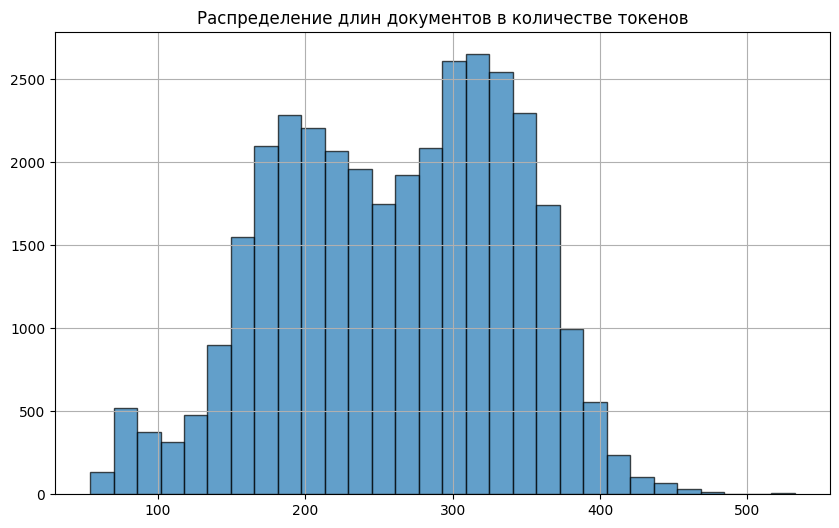

In [ ]:
from sentence_transformers import SentenceTransformer
EMBEDDING_MODEL_NAME = "Qwen/Qwen3-Embedding-0.6B"

print(f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc_str)) for doc_str in document]

# Построим график распределения длин документов, подсчитываемых как количество токенов
plt.figure(figsize=(10, 6))
plt.title("Распределение длин документов в количестве токенов")
fig = pd.Series(lengths).hist(edgecolor='black', bins=30, alpha=0.7)
plt.show()

### Поиск документов для few-shot

In [ ]:
documents = data_clean.apply(make_object_text, axis=1)
documents_val = data_eval.apply(make_object_text, axis=1)

relevances = data_clean['relevance']
relevances_val = data_eval['relevance']

In [ ]:
data_eval[data_eval['Text'] == 'уфа суши ресторан']

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,reviews_summarized,relevance


In [ ]:
data_clean[data_clean['Text'] == 'уфа суши ресторан']

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,reviews_summarized,relevance
1636,уфа суши ресторан,"Республика Башкортостан, Уфа, Первомайская ули...",Своя компания; Svoia kompaniia; Svoya kompaniy...,Ресторан,49095297099,Ресторан «Своя компания» предлагает разнообраз...,"Организация «Своя компания» — это ресторан, гд...",1.0
2132,уфа суши ресторан,"Республика Башкортостан, Уфа, Комсомольская ул...",Rest-Time; Rest-Time Holiday; Ресторан Rest-Ti...,Банкетный зал,70777375433,"Предлагает услуги ресторана и банкетного зала,...",Организация Rest-Time занимается проведением б...,0.1
5927,уфа суши ресторан,"Республика Башкортостан, Уфа, улица Энтузиасто...",Суши-Маркет; Sushi-Market,Суши-бар,229321412192,Предлагает широкий выбор суши и роллов | Филад...,Организация занимается продажей суши и онигири...,0.1
10731,уфа суши ресторан,"Республика Башкортостан, Уфа, проспект Октября...",Ресторан Честных Цен; Restaurant of fair price...,Ресторан,103924942900,Ресторан Честных Цен предлагает разнообразные ...,Организация занимается ресторанным бизнесом и ...,1.0
14920,уфа суши ресторан,"Республика Башкортостан, Уфа, Комсомольская ул...",Своя компания; Svoia kompaniia; Svoya kompaniy...,Ресторан,1123212619,Ресторан «Своя компания» предлагает разнообраз...,"Организация занимается ресторанным бизнесом, п...",1.0
18365,уфа суши ресторан,"Республика Башкортостан, Уфа, проспект Октября...",Farfor; FARFOR,Кафе,214994566417,Кафе и суши-бар Farfor предлагает широкий выбо...,Организация занимается обслуживанием кафе и до...,0.0
18654,уфа суши ресторан,"Республика Башкортостан, Уфа, Бакалинская улиц...",Фудзияма; Fujiiyama; Fudziyama,Суши-бар,118212053526,Суши-бар «Фудзияма» предлагает широкий ассорти...,Организация занимается приготовлением и достав...,1.0
21167,уфа суши ресторан,"Республика Башкортостан, Уфа, улица Ленина, 16",Ресторан Честных Цен; Restaurant of fair price...,Ресторан,1738716726,Ресторан «Честных Цен» предлагает разнообразны...,"Организация занимается ресторанным бизнесом, п...",0.1
23483,уфа суши ресторан,"Республика Башкортостан, Уфа, улица Шмидта, 158/1",Базилик; Basil seed,Ресторан,133432901108,None,None,0.0
26662,уфа суши ресторан,"Республика Башкортостан, Уфа, улица Космонавто...",Фудзияма; Fujiiyama; ИП Кислицин А. В.; Fudziyama,Суши-бар,34495907012,Суши-бар «Фудзияма» предлагает широкий выбор р...,Организация занимается предоставлением услуг в...,1.0


In [ ]:
IND = 14920
print(make_object_text(data_clean.loc[IND]))

Запрос: уфа суши ресторан.
Название: Своя компания ;  Svoia kompaniia ;  Svoya kompaniya ;  Ресторан Своя компания ;  Своя Компания
Рубрика: Ресторан
Адрес: Республика Башкортостан, Уфа, Комсомольская улица, 2
Цены: Ресторан «Своя компания» предлагает разнообразные блюда: от классических салатов и супов до мясных и рыбных деликатесов, а также широкий выбор десертов и напитков  |  пицца  |  греческий салат  |  бефстроганов  |  куриный рулет  |  цезарь с курицей  |  чизкейк  |  роллы  |  супы  |  паста  |  десерты 
Отзывы: Организация занимается ресторанным бизнесом, предоставляя разнообразные блюда и услуги. Тональность отзывов смешанная: много положительных отзывов о вкусной еде и уютной атмосфере, но есть и отрицательные отзывы о качестве блюд, обслуживании и высоких ценах. Хвалят: вкусную еду, атмосферу, обслуживание. Критикуют: высокие цены, долгое ожидание, качество некоторых блюд.


In [ ]:
rnd_index = documents.sample(1).index.item()
finded_to_lst = documents[rnd_index]
relevance_finded = relevances[rnd_index]

print(finded_to_lst)
print(relevance_finded)

Запрос: салоны красоты район новые черемушки.
Название: Студия стрижки ;  Студия Стрижки
Рубрика: Салон красоты
Адрес: Москва, Профсоюзная улица, 56
Цены: Студия стрижки предлагает широкий спектр услуг по уходу за волосами, включая стрижки, окрашивания, мелирование и химические процедуры  |  женская стрижка  |  мелирование + тонирование  |  мужская стрижка  |  окрашивание в один тон  |  осветление + тонирование + стрижка  |  химическая завивка + стрижка
Отзывы: Организация занимается стрижками, окрашиванием и другими парикмахерскими услугами. Отзывы положительные: клиенты хвалят профессионализм мастеров, качество услуг и приемлемые цены. 
0.1


### Запрос и пример для few_shot

In [ ]:
few_shot_prompt = """
Пример 1:
Запрос: уфа суши ресторан
Название: Фудзияма
Рубрика: Суши-бар
Адрес: Республика Башкортостан, Уфа, улица Космонавтов, 14
Цены: Суши-бар «Фудзияма» предлагает широкий выбор роллов, сетов и онигири, а также картофель фри
Отзывы: Организация занимается предоставлением услуг в области японской кухни, включая доставку суши и роллов.
{"relevance": 1.0, "reason": "Организация является суши баром в Уфе"}

Пример 2:
Запрос: халяль кафе саратов
Название: Палермо
Рубрика: Ресторан
Адрес: Саратов, Железнодорожная улица, 72
Цены: Ресторан «Палермо» предлагает разнообразные блюда итальянской и европейской кухни, включая салаты, пасту, пиццу, мясные и рыбные блюда, а также десерты и соусы
Отзывы: Организация занимается ресторанным обслуживанием, в меню есть пицца и другие блюда.
{"relevance": 0.1, "reason": "Это ресторан где могут подать хяляьную пищу, но он не является специализированным местом"}

Пример 3:

Запрос: скупка автомобилей деньги сразу москва
Название: Скупка фотоаппаратов
Рубрика: Комиссионный магазин
Адрес: Москва, улица Олеко Дундича, 21, корп. 3
Цены: None
Отзывы: Организация занимается скупкой фотоаппаратов и фототехники.
Ответ:
{"relevance": 0.0, "reason": "Организация не связана со скупкой авто"}

"""

In [ ]:
basic_prompt_single = """
Ты являешься системой оценки релевантности организаций для поисковой выдачи карт.

Твоя задача — определить, насколько организация соответствует поисковому запросу пользователя.

Ты получаешь:

1. Поисковый запрос пользователя
2. Информацию об организации, которая может включать:
   - название
   - категорию / рубрику
   - адрес
   - описание
   - отзывы
   - дополнительные атрибуты

---

### Основная задача

Оцени релевантность организации относительно пользовательского запроса.

---

### Классы релевантности

Используй строго следующие значения:

1.0 — Полностью релевантно
Организация напрямую соответствует намерению запроса пользователя.

0.1 — Частично релевантно
Организация может удовлетворить запрос косвенно или в качестве запасного варианта.

0.0 — Нерелевантно
Организация не соответствует намерению запроса.

---

### Правила оценки

Оцени релевантность, учитывая:

1. Намерение пользователя (intent)
   Определи, что именно пользователь хочет найти.

2. Семантическое совпадение
   Сравни запрос с названием, адресом, рубриками и описанием организации.

3. Практическую применимость
   Может ли пользователь реально воспользоваться организацией для своей цели.

---

### Приоритет факторов

Расположи по важности:

1. Категория организации
2. Название организации
3. Описание и дополнительные атрибуты
4. Адрес (используется только если указан географический запрос)

---

### Особые случаи

Если запрос общий (например "кофе"):
- Кофейня → 1.0
- Магазин с кофейным отделом → 0.1
- Несвязанная организация → 0.0

Если запрос про услугу:
- Организация предоставляет услугу напрямую → 1.0
- Организация связана с услугой косвенно → 0.1
- Услуга отсутствует → 0.0

Если информации недостаточно:
- Используй наиболее вероятную оценку на основе имеющихся данных
- Не додумывай факты

---

### Запрещено

- Использовать знания вне предоставленных данных
- Делать предположения о сервисах организации без подтверждения
- Изменять шкалу оценок

---

### Формат ответа

Ответ должен быть строго в JSON формате:

{
  "relevance": <число>,
  "reason": "<краткое объяснение>"
}

---

### Требования к объяснению

- Максимум 2 коротких предложения
- Без повторения запроса
- Без лишних рассуждений
"""

### Рассчет стоимости задачи

In [ ]:
prompt_tokenized_len = len(tokenizer.encode(basic_prompt))
few_shot_len = len(tokenizer.encode(few_shot_prompt))
max_len_text = 512

print("Lens of data (in tokens)")
print(f"Prompt: {prompt_tokenized_len} tokens")
print(f"Few shot: {few_shot_len} tokens")
print(f"Max len: {max_len_text} tokens")

sum_tokens = prompt_tokenized_len + few_shot_len + max_len_text
print(f"Sum: {sum_tokens} tokens")
print(f"Worst case {len(data_eval) * sum_tokens} tokens")

#calculate all tokens
lengths_eval = [len(tokenizer.encode(doc)) for doc in documents_val]
all_len = sum(lengths_eval) + (prompt_tokenized_len + few_shot_len) * len(data_eval)
print(f'Eval sum in tokens {sum(lengths_eval)}')
print(f"Real case {all_len} tokens")



Lens of data (in tokens)
Prompt: 722 tokens
Few shot: 528 tokens
Max len: 512 tokens
Sum: 1762 tokens
Worst case 1004340 tokens
Eval sum in tokens 149797
Real case 862297 tokens


## 2. Ollama Local Model

### 2.1 Установка модели

In [10]:
!sudo apt update
!sudo apt install -y pciutils
!sudo apt-get install zstd
!curl -fsSL https://ollama.com/install.sh | sh

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.8 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,341 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:12 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:13 https://ppa.launchpadcontent.

In [11]:
import threading
import subprocess
import time

def run_ollama_serve():
  subprocess.Popen(["ollama", "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()
time.sleep(5)

In [12]:
!ollama pull qwen2.5:14b

In [13]:
!pip install langchain-ollama

### 2.2 Промпт + few-shot

In [14]:
basic_prompt_multiple = """
Ты являешься системой оценки релевантности организаций для поисковой выдачи карт.

Твоя задача — определить релевантность организации относительно поискового запроса пользователя.

---

## Входные данные

Ты получаешь JSON-массив, где каждый элемент является ОТДЕЛЬНЫМ и НЕЗАВИСИМЫМ кейсом.

Каждый кейс имеет следующую структуру:

[{
  "id": "<уникальный идентификатор кейса>",
  "query": "<поисковый запрос пользователя>",
  "organization": {
    "name": "<название>",
    "category": "<категория / рубрика>",
    "address": "<адрес>",
    "description": "<описание>",
    "reviews": "<отзывы>"
  }
}, ...]

---

## Основная задача

Для КАЖДОГО элемента входного массива:

- оцени релевантность организации относительно его запроса
- используй ТОЛЬКО данные текущего элемента
- рассматривай каждый кейс независимо

! Запрещено:
- сравнивать кейсы между собой
- учитывать наличие или содержание других кейсов
- переносить выводы с одного кейса на другой

---

## Классы релевантности

Используй строго следующие значения:

1.0 — Полностью релевантно
Организация напрямую соответствует намерению запроса пользователя.

0.1 — Частично релевантно
Организация может удовлетворить запрос косвенно или как запасной вариант.

0.0 — Нерелевантно
Организация не соответствует намерению запроса.

---

## Правила оценки

При оценке учитывай:

1. Намерение пользователя (intent)
   Определи, что пользователь хочет найти.

2. Семантическое совпадение
   Сравни запрос с названием, категорией, описанием и атрибутами организации.

3. Практическую применимость
   Может ли пользователь реально воспользоваться данной организацией.

---

## Приоритет факторов (по убыванию важности)

1. Категория организации
2. Название организации
3. Описание и дополнительные атрибуты
4. Адрес (учитывается только при наличии географического запроса)

---

## Особые случаи

Если запрос общий (например "кофе"):
- Кофейня → 1.0
- Магазин с кофейным отделом → 0.1
- Несвязанная организация → 0.0

Если информации недостаточно:
- Используй наиболее вероятную оценку
- Не додумывай факты

## Редкий класс
Обращаю внимание, что 0.1 - достаточно редкая метка и ставится она только в крайних случаях.
По этой причине предпочитай ставить или 1.0 или 0.0, 0.1 - ставь только когда явно видно, что организация весьма косвенно может удоволетворить потребности человека.

---

## Запрещено

- Использовать знания вне предоставленных данных
- Делать предположения о сервисах организации без подтверждения
- Изменять шкалу оценок
- Добавлять комментарии вне формата ответа

---

## Формат ответа

Верни СТРОГО валидный JSON-массив следующего вида:

[
  {
    "id": "<id из входных данных>",
    "relevance": 1.0 | 0.1 | 0.0,
    "reason": "<краткое объяснение>"
  }
]

Внимательно следи за тем, чтобы "id" у входного и выходного блока совпадал!
---

## Требования к полю reason

- Не более 12 слов
- Одно короткое предложение
- Без повторения запроса
- Без общих формулировок
"""

few_shot_prompt = """
Human:
[
  {
    "id": "1",
    "query": "уфа суши ресторан",
    "organization": {
      "name": "Фудзияма",
      "category": "Суши-бар",
      "address": "Республика Башкортостан, Уфа, улица Космонавтов, 14",
      "description": "Суши-бар «Фудзияма» предлагает широкий выбор роллов, сетов и онигири, а также картофель фри",
      "reviews": "Организация занимается предоставлением услуг в области японской кухни, включая доставку суши и роллов."
    }
  },
  {
    "id": "2",
    "query": "халяль кафе саратов",
    "organization": {
      "name": "Палермо",
      "category": "Ресторан",
      "address": "Саратов, Железнодорожная улица, 72",
      "description": "Ресторан «Палермо» предлагает разнообразные блюда итальянской и европейской кухни, включая салаты, пасту, пиццу, мясные и рыбные блюда, а также десерты и соусы",
      "reviews": "Организация занимается ресторанным обслуживанием, в меню есть пицца и другие блюда."
    }
  }
]

AI:
[
  {
    "id": "1",
    "relevance": 1.0,
    "reason": "Организация является суши баром в Уфе"
  },
  {
    "id": "2",
    "relevance": 0.1,
    "reason": "Это ресторан где могут подать хяляльную пищу, но он не является специализированным местом"
  }
]

"""

#### То же самое, но с экранированием скобок.

In [15]:
def auto_escape(text):
    # Экранируем все, кроме {input}
    return text.replace('{', '{{').replace('}', '}}').replace('{{input}}', '{input}')

basic_prompt_multiple_ecr = auto_escape(basic_prompt_multiple)
few_shot_prompt_ecr = auto_escape(few_shot_prompt)

### 2.3 Making a chain

Подключение библиотек.

In [16]:
# Библиотека для олламы и лангчейн
from langchain_ollama.llms import OllamaLLM
# Парсер
from langchain_core.output_parsers import JsonOutputParser
# Импорт шаблонов
from langchain_core.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    FewShotPromptTemplate,
    PromptTemplate
)

Создание цепочки (chain)

In [17]:
# Создаем промпт с messages
# 1. Промпт zero-shot
prompt = ChatPromptTemplate.from_messages([
    ("system", basic_prompt_multiple_ecr),
    ("human", "Проанализируй следующие организации:\n{input}\n")
])

# 2. Промпт few-shot (пока что пропущен)


model = OllamaLLM(model="qwen2.5:14b",
                  temperature=0.0)

chain = prompt | model | JsonOutputParser()

### 2.4 Методы форматирования запросов. Подготовка данных.

1. Подготовка датасета

In [20]:
def process_columns(df, names_num=3, prices_num=6):
    """обработка каждого столбца"""

    # Обработка имен
    df['name'] = df['name'].apply(
        lambda x: " ; ".join(str(x).split(';')[:names_num]) if pd.notna(x) else None
    )

    # Обработка цен
    df['prices_summarized'] = df['prices_summarized'].apply(
        lambda x: " | ".join(str(x).split('|')[:prices_num]) if pd.notna(x) else None
    )

    # Обработка отзывов (берем первый элемент до первого \n)
    df['reviews_summarized'] = df['reviews_summarized'].apply(
        lambda x: str(x).split('|')[0].split('\n')[0] if pd.notna(x) else None
    )

    return df

data_clean = process_columns(data_clean)
data_eval = process_columns(data_eval)

/tmp/ipython-input-2456115501.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name'] = df['name'].apply(
/tmp/ipython-input-2456115501.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prices_summarized'] = df['prices_summarized'].apply(
/tmp/ipython-input-2456115501.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

2. Батчинг в json

In [21]:
import json

def format_row_dict(row):
    """
    Форматирование в dict запроса.
    Text 	address 	name 	normalized_main_rubric_name_ru 	permalink 	prices_summarized 	reviews_summarized 	relevance
    """
    dict_template = {
        "id" : row.name,
        "query" : row['Text'],
        "organization": {
            "name": row['name'],
            "category": row['normalized_main_rubric_name_ru'],
            "address": row['address'],
            "description": row['prices_summarized'] if row['prices_summarized'] is not None else 'None',
            "reviews": row['reviews_summarized'] if row['reviews_summarized'] is not None else 'None'
        }


    }

    return dict_template

def make_batch(data, batch_size=10, shuffle=True):
    """
    Удобный метод для создания батча
    """
    indicies = np.arange(data.index.start, data.index.stop, data.index.step)
    if shuffle:
        np.random.shuffle(indicies)

    for i in range(0, len(data), batch_size):
        batch_iter = data.loc[indicies[i:i+batch_size]]
        yield  batch_iter

def collate_batch_llm(batch_df):
    """
    Берет батч - превращает в словарь - запихивает в json
    retrun: текст в виде json
    """
    batch_items = [format_row_dict(row) for _, row in batch_df.iterrows()]

    return json.dumps(
        batch_items,
        ensure_ascii=False,
        separators=(",", ":")
    )

def truncate(text, max_len=512):
    if text is None:
        return None
    return text[:max_len]



In [22]:
# test
for batch_df in make_batch(data_eval, batch_size=10):
    llm_input = collate_batch_llm(batch_df)

    print(llm_input)
    break

[{"id":525,"query":"азс пропан ","organization":{"name":"Лукойл ;  Lukojl ;  Lukoil","category":"АЗС","address":"Пермь, Промышленная улица, 82","description":"None","reviews":"Организация занимается заправкой транспортных средств, продажей топлива и сопутствующих товаров. Отзывы в основном положительные: пользователи хвалят качество топлива, обслуживание и расположение АЗС. Критикуют высокие цены на товары и некоторые организационные моменты. "}},{"id":97,"query":"японские кафе","organization":{"name":"Тануки ;  Tanuki ;  Ресторан Тануки","category":"Ресторан","address":"Московская область, Химки, Ленинградская улица, вл16Б","description":"Ресторан «Тануки» предлагает широкий выбор суши, роллов, лапши, горячих блюд и напитков  |  маки с авокадо  |  ролл «Принцесс»  |  мисо суп  |  лапша с говядиной  |  ролл «Филадельфия» ","reviews":"Организация занимается предоставлением услуг в сфере питания, специализируется на японской кухне. Отзывы преимущественно положительные: множество пользова

### 2.5 Методы для инференса. Get answers.

In [18]:
DEBUG = False
from tqdm.notebook import tqdm
from langchain_core.exceptions import OutputParserException

def get_model_outputs(data: pd.DataFrame, chain, batch_size=10, max_retries=2):
    """
    Inference
    Метод для прогона данных и получения результатов.
    """
    result = []

    # создаем все возмножные батчи
    batches = list(make_batch(data, batch_size=batch_size, shuffle=False))

    for batch_df in tqdm(batches, desc="LLM inference", total=len(batches)):
        input_batch = collate_batch_llm(batch_df)

        # попытка (для случая неверного ответа)
        attempt = 0
        while attempt <= max_retries:
            try:
                model_result = chain.invoke({"input": input_batch})
                result.extend(model_result)
                break

            except OutputParserException as ex:
                attempt += 1

                if attempt > max_retries:
                    print("JSON parsing failed. Batch skipped.")
                    if DEBUG:
                        print("Raw input:")
                        print(input_batch)
                    break

                input_batch = (
                    input_batch
                    + "\n\n ВАЖНО: Ответь СТРОГО валидным JSON без текста вне JSON."
                )

        if DEBUG:
            break


    result_df = parse_result(result, data)
    return result_df

def parse_result(result, orig_df: pd.DataFrame):
    """
    Превращает результат в полноценный датафрейм c колонками.
    """

    # преобразование в датафрейм
    answer_df = pd.DataFrame(result)
    # переименование колонок
    answer_df = answer_df.set_index('id')
    answer_df = answer_df.rename(columns={'relevance': 'relevance_llm', 'reason': 'reason'})

    # результирующий датафрейм
    result_df = pd.merge(orig_df, answer_df, left_index=True, right_index=True, how='inner')

    return result_df

In [23]:
answer = get_model_outputs(data_eval, chain)

LLM inference:   0%|          | 0/57 [00:00<?, ?it/s]

In [36]:
answer.sample(5)

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,reviews_summarized,relevance,relevance_llm,reason
146,пицца кострома,"Кострома, улица Дзержинского, 23",Ozon,Пункт выдачи,17943669173,None,Организация занимается выдачей заказов интерне...,0.0,0.0,"Пункт выдачи, не пицца"
118,Итальянская кухня,"Краснодарский край, Анапа, улица Ленина, 3",Ла Веранда ; La Veranda ; La veranda,Ресторан,1341287556,None,"Организация занимается ресторанным бизнесом, п...",1.0,0.0,"Итальянский ресторан, не роллы"
5,сеть быстрого питания,"Санкт-Петербург, 1-я Красноармейская улица, 15",Rostic's ; KFC ; Ресторан быстрого питания KFC,Быстрое питание,1219173871,Rostic's предлагает различные наборы быстрого ...,"Организация занимается быстрым питанием, предо...",1.0,1.0,Быстрое питание
155,китайский ресторан в санкт-петербурге на невском,"Санкт-Петербург, Невский проспект, 95",Кореана Light ; Koreana Light ; Koreana light,Кафе,1724800998,Кафе «Кореана Light» предлагает широкий выбор ...,"Организация занимается подачей корейских блюд,...",0.0,0.0,Корейское кафе не соответствует запросу
348,Сервисный центр Xiaomi,"Москва, Благовещенский переулок, 5",Xiaomi ; HitBuy ; Xiaomi Mi Store,Магазин электроники,167434681255,Магазин электроники и бытовой техники Xiaomi п...,Организация занимается продажей и ремонтом тех...,1.0,0.1,"Сервисный центр, косвенное соответствие"


In [25]:
answer.to_csv('answer.csv')

### 2.6 Оценка решения

In [28]:
from sklearn.metrics import classification_report
def calculate_metrics(result_dataframe: pd.DataFrame) -> None:

    ind2label = {0:0.0, 1:1.0, 2:0.1}
    label2ind = {0.0:0, 1.0:1, 0.1:2}

    y_trues = result_dataframe['relevance'].map(label2ind)
    y_preds = result_dataframe['relevance_llm'].map(label2ind)



    report = classification_report(y_trues, y_preds)

    print(report)

calculate_metrics(answer)



              precision    recall  f1-score   support

           0       0.37      0.80      0.51        75
           1       0.71      0.40      0.51       142
           2       0.11      0.03      0.05        33

    accuracy                           0.47       250
   macro avg       0.40      0.41      0.36       250
weighted avg       0.53      0.47      0.45       250



## Описание опытов.

Опыт показывает, что на большом количестве батчей маленькая модель может путать ответы. Вывод:
* использовать более мощную модель.
Небольшие фиксы которые могут помочь:
* батч необходимо уменьшать. Например взять 5 примеров
* использовать ризонинг - намного дороже
* сделать езе один запрос у модели и попросить ее проверить не перепутала ли другая модель чего

Все эти улучшения должны помочь избавиться от ошибок, и качество должно вырасти.